# Tworzenie wykresu PDP dla wytłumaczenia działania modelu badającego złośliwość nowotworu piersi
Na podastawie: [PARTIAL DEPENDENCE PLOT](http://ethen8181.github.io/machine-learning/model_selection/partial_dependence/partial_dependence.html)

Z wykorzystanie datasetu: [Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)

# Import bibliotek

In [1]:
import numpy as np
import pandas as pandas
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Czytanie danych

In [2]:
data_path = '../input/breast-cancer-wisconsin-data/data.csv'
data = pandas.read_csv(data_path)

In [3]:
data['benign'] = (data.diagnosis == 'M').astype(int)
data.drop(['id', 'diagnosis','Unnamed: 32'], axis=1, inplace=True)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data, data['benign'], test_size = 0.2, random_state = 1234, stratify = data['benign'])
X_train.drop(['benign'], axis=1, inplace=True)

# Trenowanie modelu

In [5]:
model = RandomForestClassifier(n_estimators = 50, random_state = 1234)
model.fit(X_train, y_train)
model = model.predict_proba

# Funkcje PDP

In [6]:
def pd(data, feature, model):
    
    feature_grid = np.percentile(data[feature], range(0,100,2))
    feature_grid = list(set(feature_grid))
    feature_grid.sort()
    feature_grid=np.array(feature_grid)
    grid_size = int((data.shape[0] / feature_grid.size) + (data.shape[0] % feature_grid.size > 0))
        
    results=[]
    for i in range(0,data.shape[0], grid_size):
        batch = data[i:i + grid_size].reset_index(drop = True)
        results = pred(batch,feature_grid,feature,model)


    results = results[0]
    pdp = results.values.mean(axis = 0)
    pdp = pdp - pdp[0]
        
    plot(results,feature,pdp)

def pred(batch, feature_grid, feature, model):
    index = []
    for k in batch.index.values:
        for i in range(0,feature_grid.size,1):
            index.append(k)

    exp = batch.iloc[index].copy()
    exp[feature] = np.tile(feature_grid, batch.shape[0])

    predict = model(exp)
    predict = predict[:, 1]
    predict = predict.reshape((batch.shape[0], feature_grid.size))
    predict = pandas.DataFrame(predict)

   
    return [predict]

def plot(results,feature,pdp):
    plt.figure()
    ax = plt.subplot(111)
    x = results.columns
        
    ax.set_title('PDP dla: {}'.format(feature))
    ax.plot(x, pdp,marker = 'o', markersize = 4)
    ax.plot(x, [0] * pdp.size,linestyle = '--', linewidth = 1.5)
    ax.fill_between(x, pdp + results.values.std(axis = 0), pdp - results.values.std(axis = 0), alpha = 0.0)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.grid(True, 'major', 'x', ls = '--')
    ax.grid(True, 'major', 'y', ls = '--')
    plt.show()

# Wykresy PDP dla różnych współczynników

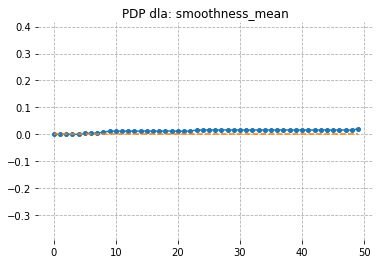

In [7]:
pd(X_train, feature = 'smoothness_mean', model = model)

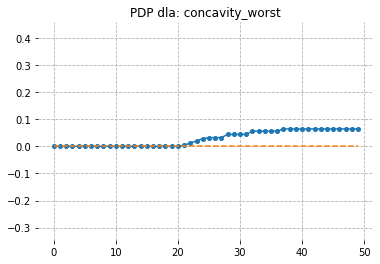

In [8]:
pd(X_train, feature = 'concavity_worst', model = model)